In [1]:
import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.expressions import Beta, DefineVariable, Derive, log
import math
import random
import biogeme.results as res
from random import randint
import os, inspect
from sklearn.utils import shuffle
import numpy as np
import scipy.stats as s
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#selected_region = 'CD9'

In [2]:
raw_data = pd.read_csv('NHTS_home_based_spillover_trips.csv')
print(raw_data.columns)
raw_data = raw_data.dropna()
raw_data[['home_geoid', 'o_geoid', 'd_geoid']] = raw_data[['home_geoid', 'o_geoid', 'd_geoid']].astype(int)
raw_data.loc[:, 'trip_id'] = raw_data.reset_index().index + 1
print(len(raw_data))
raw_data.head(5)

Index(['Unnamed: 0', 'houseid', 'personid', 'tdtrpnum', 'trptrans',
       'home_geoid', 'spatial_id_x', 'fips_st_x', 'st_code_x', 'state_x',
       'cty_x', 'ctyname_x', 'cbsa_x', 'cbsaname_x', 'population',
       'hholds_total', 'pop_region', 'hu_region', 'aland2017', 'awater2017',
       'area_land_region', 'area_water_region', 'home_geotype',
       'home_microtype', 'geo_micro_type', 'wtperfin', 'hhfaminc', 'whytrp1s',
       'trpmiles', 'strttime', 'endtime', 'trippurp', 'h_geotype',
       'orig_country', 'o_geoid', 'dest_country', 'd_geoid', 'o_microtype',
       'o_geotype', 'd_microtype', 'd_geotype', 'wthhfin', 'hbhur',
       'populationGroupType', 'trip_purpose', 'distanceBin', 'start hour',
       'end hour', 'travel time', 'mode', 'time period', 'h_origin', 'h_dest',
       'nhb', 'trip_tag', 'dest_geotype', 'dest_microtype', 'dest_geoid',
       'orig_geotype', 'orig_microtype', 'orig_geoid', 'dest_st_code',
       'dest_state', 'orig_st_code', 'orig_state', 'FID', 'GE

,Unnamed: 0,houseid,personid,tdtrpnum,trptrans,home_geoid,spatial_id_x,fips_st_x,st_code_x,state_x,...,st_code_y,state_y,cty_y,ctyname_y,cbsa_y,cbsaname_y,spatial_id_y,geotype,geotype_imp,trip_id
0,12,30000900,1,2,5,54069001800,48540,54,WV,West Virginia,...,WV,West Virginia,54069.0,"Ohio County, WV",48540.0,"Wheeling, WV-OH",48540.0,C,False,1
1,18,30000900,1,8,5,54069001800,48540,54,WV,West Virginia,...,WV,West Virginia,54069.0,"Ohio County, WV",48540.0,"Wheeling, WV-OH",48540.0,C,False,2
2,27,30001318,1,2,4,46127020300,43580,46,SD,South Dakota,...,SD,South Dakota,46127.0,"Union County, SD",43580.0,"Sioux City, IA-NE-SD",43580.0,B,False,3
3,28,30001318,1,3,4,46127020300,43580,46,SD,South Dakota,...,SD,South Dakota,46127.0,"Union County, SD",43580.0,"Sioux City, IA-NE-SD",43580.0,B,False,4
4,30,30001360,1,1,3,45003021203,12260,45,SC,South Carolina,...,SC,South Carolina,45003.0,"Aiken County, SC",12260.0,"Augusta-Richmond County, GA-SC",12260.0,C,False,5


In [3]:
# fit survival rate based on distance
params = s.exponweib.fit(raw_data['trpmiles'], floc=0, f0=1)
shape = params[1]
scale = params[3]
print(params)
print('shape:', shape)
print('scale:',scale)

(1, 0.6973874258897281, 0, 60.29068174536817)
shape: 0.6973874258897281
scale: 60.29068174536817


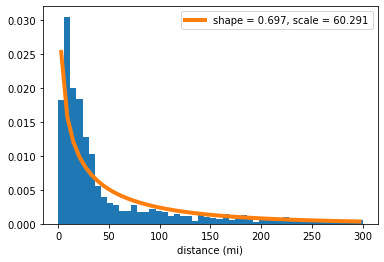

In [5]:
values,bins,hist = plt.hist(raw_data['trpmiles'],bins=50, range=(0,300), density = True)
center = (bins[:-1] + bins[1:]) / 2.

# Using all params and the stats function
legend_text = 'shape = {a}, scale = {b}'.format(a = np.round(shape, 3), b = np.round(scale, 3))
plt.plot(center,s.exponweib.pdf(center,*params),lw=4,label=legend_text)
# plt.plot(center,s.exponweib.sf(center,*params),lw=4,label='survival function')
plt.xlabel('distance (mi)')
plt.legend()
# plot_dir = 'Plot/' + selected_state
# isExist = os.path.exists(plot_dir)
# if not isExist:

#    # Create a new directory because it does not exist
#    os.makedirs(plot_dir)
# plt.savefig(plot_dir + 'fitted_travel_time_curve.png', dpi = 300)

In [6]:
# load additional data

path_to_prj = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/data'
os.chdir(path_to_prj)

microtype_lookup_file = 'ccst_geoid_key_tranps_geo_with_imputation.csv'
microtype_lookup = pd.read_csv('Network/' + microtype_lookup_file, sep = ',')
microtype_lookup_short = microtype_lookup[['GEOID', 'geotype', 'microtype']]
microtype_lookup_short['GEOID'] = microtype_lookup_short['GEOID'].astype(int)

# load size term (employment size, accessibility, etc)
employment_file = 'wac_tract_2017.csv'
employment_data = pd.read_csv('Network/' + employment_file, sep = ',')
employment_data_short = employment_data[['trct',  'jobs_total']]
# print(employment_data_short.head(5))

opportunity_file = 'opportunity_counts_tract.csv'
opportunity_data = pd.read_csv('Network/' + opportunity_file, sep = ',')
# opportunity_data.head(5)

mode_availability_file = 'modeaccessibility.csv'
mode_availability = pd.read_csv('Network/' + mode_availability_file, sep = ',')
mode_availability.head(5)


,Unnamed: 0,geoid,bike,rail,bus
0,1,1001020100,0,0,0
1,2,1001020200,0,1,0
2,3,1001020300,0,0,0
3,4,1001020400,0,0,0
4,5,1001020500,0,0,0


In [7]:
# construct data for mode choice
import matplotlib.pyplot as plt

raw_data = raw_data.loc[raw_data['trip_tag'] != 'nhb']
raw_data.loc[:, 'orig_geoid'] = raw_data.loc[:, 'home_geoid']
raw_data.loc[:, 'dest_geoid'] = raw_data.loc[:, 'd_geoid']

# raw_data.loc[raw_data['trip_tag'] == 'dest', 'orig_geoid'] = raw_data.loc[:, 'home_geoid']
raw_data.loc[raw_data['trip_tag'] == 'dest', 'dest_geoid'] = raw_data.loc[:, 'o_geoid']
training_data = raw_data[['trip_id', 'orig_geoid', 'orig_st_code', 
                          'dest_geoid', 'dest_st_code', 'dest_geotype', 'wtperfin',
                          'dest_microtype', 'trip_purpose', 'populationGroupType']]
training_data = training_data.dropna()
print(training_data.isnull().values.any())
sample_training_data = training_data
print(len(sample_training_data))
sample_training_data.head(5)

False
5275


,trip_id,orig_geoid,orig_st_code,dest_geoid,dest_st_code,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType
0,1,54069001800,WV,42003414102,PA,A,1487.848988,4.0,work,medium-income
1,2,54069001800,WV,42125752700,PA,A,1487.848988,3.0,home,medium-income
2,3,46127020300,SD,19193000700,IA,B,402.708970,3.0,leisure,high-income
3,4,46127020300,SD,19193000700,IA,B,402.708970,3.0,home,high-income
4,5,45003021203,SC,13245011000,GA,C,61.059184,1.0,medical,high-income


WV
SD
SC
CA
WI
IA
AZ
GA
TN
NC
PA
OH
MO
VT
ID
IN
TX
WA
IL
FL
MA
KY
OK
WY
MN
NE
KS
ND
OR
MS
AL
MI
ME
AR
NM
CO
LA
NV
UT
5045


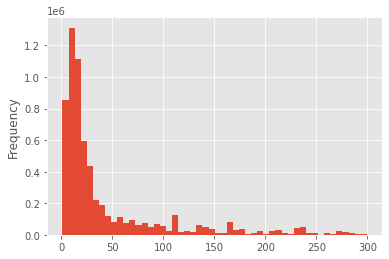

<AxesSubplot:ylabel='Frequency'>

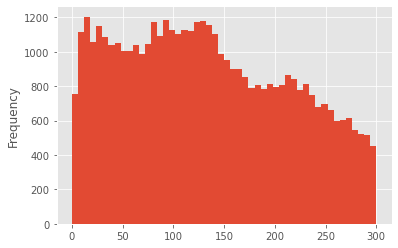

In [8]:
# create random sample for non-chosen destinations
power_coeff = 1.05 # for comparison 
# params = [1, 1.132, 0, 0.35] # fitted Weibull parameters 

# assign distance
orig_states = sample_training_data.orig_st_code.unique()
chosen_data = None
non_chosen_data = None

for st in orig_states:
    print(st)
    
    # processing chosen data
    sample_training_selected = \
    sample_training_data.loc[sample_training_data['orig_st_code'] == st]
    dist_matrix_long = \
    pd.read_csv('Network/combined/distance_matrix_by_tracts_' + st + '.csv')
    
    dist_matrix_long['destination'] = dist_matrix_long['destination'].astype(int)
    dist_matrix_long['origin'] = dist_matrix_long['origin'].astype(int)
    dist_matrix_long = pd.merge(dist_matrix_long, microtype_lookup_short,
                                left_on = 'destination', right_on = 'GEOID',
                                how = 'left')
    dist_matrix_long = dist_matrix_long[['origin', 'destination', 
                                         'geotype', 'microtype', 
                                         'distance']]

    sample_training_selected = \
    pd.merge(sample_training_selected, dist_matrix_long,
             left_on = ['orig_geoid', 'dest_geoid'],
             right_on = ['origin', 'destination'],
             how = 'inner')
    if len(sample_training_selected)> 0:
        chosen_data = pd.concat([chosen_data, sample_training_selected])
    
    # generate non-chosen data
        sample_training_nonchosen = \
        sample_training_selected[['trip_id', 'orig_geoid', 'dest_geotype', 
                              'dest_microtype',	'trip_purpose', 
                                  'populationGroupType']].copy()
        sample_training_nonchosen = \
        pd.merge(sample_training_nonchosen, 
                 dist_matrix_long,
                 left_on = ['orig_geoid'],
                 right_on = ['origin'], 
                 how = 'left')
        grouping_var = ['trip_id', 'orig_geoid']
        # define location selection criteria
        sample_training_nonchosen.loc[:, 'probability'] = \
        s.exponweib.sf(sample_training_nonchosen.loc[:, 'distance'], *params)

        sample_training_nonchosen = \
        sample_training_nonchosen.groupby(grouping_var).sample(n=9, replace = True, 
                                                     weights = sample_training_nonchosen['probability'], random_state=1)
        non_chosen_data = pd.concat([non_chosen_data, sample_training_nonchosen])
    


chosen_data.loc[:,'chosen'] = 1
print(len(chosen_data))
chosen_data = chosen_data[['trip_id', 'orig_geoid', 'orig_st_code',
                           'dest_geoid', 'dest_st_code', 'dest_geotype', 
                           'wtperfin', 'dest_microtype', 'trip_purpose', 
                           'populationGroupType', 'distance', 'chosen']]
plt.style.use('ggplot')
chosen_data['distance'].plot(kind="hist", weights = chosen_data["wtperfin"], bins = 50)
plt.savefig('Plot/car_trip_distance_spillover.png', dpi = 200)
plt.show()
chosen_data.head(5)

non_chosen_data.loc[:, 'chosen'] = 0
non_chosen_data = non_chosen_data[['trip_id', 'orig_geoid', 'destination', 'dest_geotype', 
                              'dest_microtype',	'trip_purpose', 'populationGroupType', 
                               'distance', 'chosen']]
non_chosen_data = non_chosen_data.rename(columns = {'destination': 'dest_geoid'})
non_chosen_data['distance'].plot(kind="hist", bins = 50)

In [9]:
# combine data and create a training set
destination_choice_data = pd.concat([chosen_data, non_chosen_data])
destination_choice_data = shuffle(destination_choice_data)
print(len(destination_choice_data))
destination_choice_data = destination_choice_data.sort_values('trip_id')
# append size term 
destination_choice_data = pd.merge(destination_choice_data, 
                                   employment_data_short,
                                   left_on = 'dest_geoid',
                                   right_on = 'trct',
                                   how = 'left')
                                   
destination_choice_data['alternative']=destination_choice_data.groupby('trip_id').cumcount()+1
destination_choice_data['choice'] = 0
destination_choice_data.loc[destination_choice_data['chosen'] == 1, 'choice'] = \
destination_choice_data.loc[destination_choice_data['chosen'] == 1, 'alternative']

destination_choice_data.head(20)

50450


,trip_id,orig_geoid,orig_st_code,dest_geoid,dest_st_code,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType,distance,chosen,trct,jobs_total,alternative,choice
0,1,54069001800,NaN,24025303300,NaN,A,NaN,4.0,work,medium-income,227.725630,0,2.402530e+10,1610.0,1,0
1,1,54069001800,WV,42003414102,PA,A,1487.848988,4.0,work,medium-income,52.297885,1,4.200341e+10,1870.0,2,2
2,1,54069001800,NaN,39067975900,NaN,A,NaN,4.0,work,medium-income,24.068686,0,3.906798e+10,456.0,3,0
3,1,54069001800,NaN,39053953600,NaN,A,NaN,4.0,work,medium-income,117.719781,0,3.905395e+10,461.0,4,0
4,1,54069001800,NaN,26163504100,NaN,A,NaN,4.0,work,medium-income,203.422628,0,2.616350e+10,124.0,5,0
5,1,54069001800,NaN,26093731100,NaN,A,NaN,4.0,work,medium-income,248.829306,0,2.609373e+10,139.0,6,0
6,1,54069001800,NaN,39035177403,NaN,A,NaN,4.0,work,medium-income,109.787864,0,3.903518e+10,417.0,7,0
7,1,54069001800,NaN,10001040203,NaN,A,NaN,4.0,work,medium-income,276.016336,0,1.000104e+10,3029.0,8,0
8,1,54069001800,NaN,39029951500,NaN,A,NaN,4.0,work,medium-income,54.129302,0,3.902995e+10,805.0,9,0
9,1,54069001800,NaN,42041011301,NaN,A,NaN,4.0,work,medium-income,194.105561,0,4.204101e+10,2592.0,10,0


In [10]:
# check count of alternatives
destination_choice_data.loc[:, 'alt_count'] = destination_choice_data.groupby('trip_id')['alternative'].transform('count')
print(destination_choice_data.alt_count.unique())
destination_choice_data = \
destination_choice_data.loc[destination_choice_data['alt_count'] == 10]

[10]


In [11]:
# append opportunity count
# opportunity_data.head(5)
opportunity_data.loc[:, 'num_edu'] = opportunity_data.loc[:, 'num_schools'] + \
opportunity_data.loc[:, 'num_jrcollege'] + opportunity_data.loc[:, 'num_childcare']

opportunity_data.loc[:, 'num_med'] = opportunity_data.loc[:, 'num_hosp'] + \
opportunity_data.loc[:, 'num_pharm'] + opportunity_data.loc[:, 'num_urgentcare']

opportunity_data.loc[:, 'num_ent'] = opportunity_data.loc[:, 'num_parks']

opportunity_data_short = opportunity_data[['GEOID', 'num_edu', 'num_med', 'num_ent']]

destination_choice_data = pd.merge(destination_choice_data, 
                                   opportunity_data_short,
                                   left_on = 'dest_geoid',
                                   right_on = 'GEOID',
                                   how = 'left')


mode_availability.loc[:, 'transit'] = 0
criteria = (mode_availability['rail'] == 1) | ((mode_availability['bus'] == 1))
mode_availability.loc[criteria, 'transit'] = 1
mode_availability_short = mode_availability[['geoid', 'transit']]

destination_choice_data = pd.merge(destination_choice_data, 
                                   mode_availability_short,
                                   left_on = 'dest_geoid',
                                   right_on = 'geoid',
                                   how = 'left')

destination_choice_data.head(5)

,trip_id,orig_geoid,orig_st_code,dest_geoid,dest_st_code,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType,...,jobs_total,alternative,choice,alt_count,GEOID,num_edu,num_med,num_ent,geoid,transit
0,1,54069001800,NaN,24025303300,NaN,A,NaN,4.0,work,medium-income,...,1610.0,1,0,10,24025303300,4,1,2,24025303300,1
1,1,54069001800,WV,42003414102,PA,A,1487.848988,4.0,work,medium-income,...,1870.0,2,2,10,42003414102,4,2,0,42003414102,1
2,1,54069001800,NaN,39067975900,NaN,A,NaN,4.0,work,medium-income,...,456.0,3,0,10,39067975900,0,0,0,39067975900,1
3,1,54069001800,NaN,39053953600,NaN,A,NaN,4.0,work,medium-income,...,461.0,4,0,10,39053953600,3,0,1,39053953600,0
4,1,54069001800,NaN,26163504100,NaN,A,NaN,4.0,work,medium-income,...,124.0,5,0,10,26163504100,0,0,0,26163504100,1


In [12]:
choice = destination_choice_data.loc[destination_choice_data['chosen'] == 1, 
                                     ['trip_id', 'choice', 'trip_purpose', 'populationGroupType']]

choice.loc[:, 'school'] = 0
choice.loc[choice['trip_purpose'] == 'school', 'school'] = 1

choice.loc[:, 'medical'] = 0
choice.loc[choice['trip_purpose'] == 'medical', 'medical'] = 1

choice.loc[:, 'leisure'] = 0
choice.loc[choice['trip_purpose'] == 'leisure', 'leisure'] = 1

# print(destination_choice_data.loc[destination_choice_data['alternative'] == 11])
# factor_0 = pd.pivot_table(destination_choice_data, values='travel_time_h', index=['trip_id'],
#                     columns=['alternative'], aggfunc=np.mean)
# factor_0.columns = ['time_' + str(i+1) for i in range(10)]
# factor_0 = factor_0.reset_index()

factor_1 = pd.pivot_table(destination_choice_data, values='distance', 
                          index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_1.columns = ['distance_' + str(i+1) for i in range(10)]
factor_1 = factor_1.reset_index()
# factor_1.head(5)

factor_2 = pd.pivot_table(destination_choice_data, values='jobs_total', 
                          index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_2.columns = ['emp_' + str(i+1) for i in range(10)]
factor_2 = factor_2.fillna(1)
factor_2 = factor_2.reset_index()

factor_3 = pd.pivot_table(destination_choice_data, values='num_edu', 
                          index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_3.columns = ['edu_' + str(i+1) for i in range(10)]
factor_3 = factor_3.fillna(0)
factor_3 = factor_3.reset_index()

factor_4 = pd.pivot_table(destination_choice_data, values='num_med', 
                          index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_4.columns = ['med_' + str(i+1) for i in range(10)]
factor_4 = factor_4.fillna(0)
factor_4 = factor_4.reset_index()

factor_5 = pd.pivot_table(destination_choice_data, values='transit', 
                          index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_5.columns = ['transit_' + str(i+1) for i in range(10)]
factor_5 = factor_5.fillna(0)
factor_5 = factor_5.reset_index()

factor_6 = pd.pivot_table(destination_choice_data, values='num_ent', 
                          index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_6.columns = ['ent_' + str(i+1) for i in range(10)]
factor_6 = factor_6.fillna(0)
factor_6 = factor_6.reset_index()
# factor_2.head(5)

destination_choice_data_wide = pd.merge(choice, factor_1, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_2, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_3, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_4, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_5, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_6, on = 'trip_id', how = 'left')

destination_choice_data_wide.head(5)

,trip_id,choice,trip_purpose,populationGroupType,school,medical,leisure,distance_1,distance_2,distance_3,...,ent_1,ent_2,ent_3,ent_4,ent_5,ent_6,ent_7,ent_8,ent_9,ent_10
0,1,2,work,medium-income,0,0,0,227.725630,52.297885,24.068686,...,2,0,0,1,0,0,0,0,0,1
1,2,6,home,medium-income,0,0,0,287.660135,70.163912,52.930964,...,1,0,1,0,3,0,1,1,0,0
2,3,4,leisure,high-income,0,0,1,164.877593,99.175390,241.071724,...,2,2,2,3,0,3,2,2,0,0
3,4,10,home,high-income,0,0,0,227.566906,98.046343,100.483601,...,3,5,4,5,1,0,0,1,1,3
4,5,1,medical,high-income,0,1,0,14.390249,212.091760,173.492838,...,0,0,1,0,1,1,2,0,0,0


In [13]:
# add availability
destination_choice_data_wide.loc[:, 'av_1'] = 1
destination_choice_data_wide.loc[:, 'av_2'] = 1
destination_choice_data_wide.loc[:, 'av_3'] = 1
destination_choice_data_wide.loc[:, 'av_4'] = 1
destination_choice_data_wide.loc[:, 'av_5'] = 1
destination_choice_data_wide.loc[:, 'av_6'] = 1
destination_choice_data_wide.loc[:, 'av_7'] = 1
destination_choice_data_wide.loc[:, 'av_8'] = 1
destination_choice_data_wide.loc[:, 'av_9'] = 1
destination_choice_data_wide.loc[:, 'av_10'] = 1

In [14]:
# fit biogeme model by income group
inc_levels = destination_choice_data_wide.loc[:, 'populationGroupType'].unique()
for inc_level in inc_levels:
    destination_choice_data_biogeme = \
    destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == inc_level]
    destination_choice_data_biogeme = \
    destination_choice_data_biogeme.drop(columns=['trip_purpose', 'populationGroupType'])
    database = db.Database('destination_choice', destination_choice_data_biogeme)
    globals().update(database.variables)
    database.fullData
    # define parameters
    B_SIZE = Beta('B_SIZE', 0, 0, 1, 0)
    B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
#     B_TIME = Beta('B_TIME', 0, None, None, 0)
    B_EMP = Beta('B_EMP', 1, 0.00001, 1000, 0)
    B_EDU = Beta('B_EDU', 1, 0.00001, 1000, 0)
    B_MED = Beta('B_MED', 1, 0.00001, 1000, 0)
    B_TRN = Beta('B_TRN', 0, None, None, 0)
    B_ENT = Beta('B_ENT', 1, 0.00001, 1000, 0)

    V1 = B_SIZE * log(emp_1 + B_EDU * school * edu_1 + B_ENT * leisure * ent_1) + \
    B_DISTANCE * distance_1 + B_TRN * transit_1 
    V2 = B_SIZE * log(emp_2 + B_EDU * school * edu_2 + B_ENT * leisure * ent_2) + \
    B_DISTANCE * distance_2 + B_TRN * transit_2 
    V3 = B_SIZE * log(emp_3 + B_EDU * school * edu_3 + B_ENT * leisure * ent_3) + \
    B_DISTANCE * distance_3 + B_TRN * transit_3 
    V4 = B_SIZE * log(emp_4 + B_EDU * school * edu_4 + B_ENT * leisure * ent_4) + \
    B_DISTANCE * distance_4 + B_TRN * transit_4 
    V5 = B_SIZE * log(emp_5 + B_EDU * school * edu_5 + B_ENT * leisure * ent_5) + \
    B_DISTANCE * distance_5 + B_TRN * transit_5 
    V6 = B_SIZE * log(emp_6 + B_EDU * school * edu_6 + B_ENT * leisure * ent_6) + \
    B_DISTANCE * distance_6 + B_TRN * transit_6
    V7 = B_SIZE * log(emp_7 + B_EDU * school * edu_7 + B_ENT * leisure * ent_7) + \
    B_DISTANCE * distance_7 + B_TRN * transit_7  
    V8 = B_SIZE * log(emp_8 + B_EDU * school * edu_8 + B_ENT * leisure * ent_8) + \
    B_DISTANCE * distance_8 + B_TRN * transit_8 
    V9 = B_SIZE * log(emp_9 + B_EDU * school * edu_9 + B_ENT * leisure * ent_9) + \
    B_DISTANCE * distance_9 + B_TRN * transit_9 
    V10 = B_SIZE * log(emp_10 + B_EDU * school * edu_10 + B_ENT * leisure * ent_10) + \
    B_DISTANCE * distance_10 + B_TRN * transit_10 

    V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
        6: V6, 7: V7, 8: V8, 9: V9, 10: V10}
    
    av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
         6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

    logprob = models.loglogit(V, av, choice)
    biogeme = bio.BIOGEME(database, logprob)
    biogeme.modelName = 'ml_destination_spillover_'+ inc_level
    biogeme.calculateNullLoglikelihood(av)

    # Estimate the parameters
    results = biogeme.estimate()

    # Get the results in a pandas table
    pandasResults = results.getEstimatedParameters()
    goodness_of_fit = results.getGeneralStatistics()
    
    print('estimation results for households ' + inc_level)
    print(pandasResults)
    print(goodness_of_fit['Rho-square for the null model'][0])

estimation results for households medium-income
                Value  Active bound        Std err         t-test   p-value  \
B_DISTANCE  -0.020353           0.0   5.267734e-04  -3.863657e+01  0.000000   
B_EDU        0.000010           1.0  1.797693e+308  5.562685e-314  1.000000   
B_ENT       43.252990           0.0   4.210087e+01   1.027366e+00  0.304248   
B_SIZE       0.707163           0.0   2.455373e-02   2.880063e+01  0.000000   
B_TRN       -0.217063           0.0   6.626296e-02  -3.275787e+00  0.001054   

            Rob. Std err   Rob. t-test  Rob. p-value  
B_DISTANCE      0.000740 -2.750365e+01      0.000000  
B_EDU         130.283366  7.675577e-08      1.000000  
B_ENT          37.327283  1.158750e+00      0.246558  
B_SIZE          0.024004  2.945974e+01      0.000000  
B_TRN           0.063295 -3.429394e+00      0.000605  
0.3814342020302933
estimation results for households high-income
                 Value     Std err     t-test   p-value  Rob. Std err  \
B_DISTANC

In [15]:
# fit low-income separately
destination_choice_data_biogeme = \
destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'low-income']
destination_choice_data_biogeme = \
destination_choice_data_biogeme.drop(columns=['trip_purpose', 'populationGroupType'])
database = db.Database('destination_choice', destination_choice_data_biogeme)
globals().update(database.variables)
database.fullData
# define parameters
B_SIZE = Beta('B_SIZE', 0, 0, 1, 0)
B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_EMP = Beta('B_EMP', 1, 0.00001, 1000, 0)
B_EDU = Beta('B_EDU', 1, 0.00001, 1000, 0)
B_MED = Beta('B_MED', 1, 0.00001, 1000, 0)
B_TRN = Beta('B_TRN', 0, None, None, 0)

V1 = B_SIZE * log(emp_1) + \
B_DISTANCE * distance_1 + B_TRN * transit_1
V2 = B_SIZE * log(emp_2) + \
B_DISTANCE * distance_2 + B_TRN * transit_2
V3 = B_SIZE * log(emp_3) + \
B_DISTANCE * distance_3 + B_TRN * transit_3
V4 = B_SIZE * log(emp_4) + \
B_DISTANCE * distance_4 + B_TRN * transit_4
V5 = B_SIZE * log(emp_5) + \
B_DISTANCE * distance_5 + B_TRN * transit_5
V6 = B_SIZE * log(emp_6) + \
B_DISTANCE * distance_6 + B_TRN * transit_6
V7 = B_SIZE * log(emp_7) + \
B_DISTANCE * distance_7 + B_TRN * transit_7 
V8 = B_SIZE * log(emp_8) + \
B_DISTANCE * distance_8 + B_TRN * transit_8
V9 = B_SIZE * log(emp_9) + \
B_DISTANCE * distance_9 + B_TRN * transit_9
V10 = B_SIZE * log(emp_10) + \
B_DISTANCE * distance_10 + B_TRN * transit_10

V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
    6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
     6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

logprob = models.loglogit(V, av, choice)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_destination_' + selected_region + '_low-income'
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
goodness_of_fit = results.getGeneralStatistics()

print('estimation results for households low-income')
print(pandasResults)
print(goodness_of_fit['Rho-square for the null model'][0])

estimation results for households low-income
               Value   Std err     t-test   p-value  Rob. Std err  \
B_DISTANCE -0.129208  0.008177 -15.801365  0.000000      0.012157   
B_SIZE      0.571926  0.034653  16.504488  0.000000      0.033992   
B_TRN       1.431704  0.463809   3.086838  0.002023      0.444533   

            Rob. t-test  Rob. p-value  
B_DISTANCE   -10.628280      0.000000  
B_SIZE        16.825162      0.000000  
B_TRN          3.220695      0.001279  
0.15688518275836993


In [65]:
destination_choice_data_biogeme.iloc[[7303]]

,trip_id,choice,school,medical,leisure,distance_1,distance_2,distance_3,distance_4,distance_5,...,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,av_10
26779,38347,6,0,0,0,24.587556,5.203491,1.198152,5.203491,9.329579,...,1,1,1,1,1,1,1,1,1,1


In [64]:
# failed attempt...

# destination_choice_data_wide.loc[:, 'high_income'] = 1
# destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'high-income', 
#                                  'high_income'] = 1

# destination_choice_data_wide.loc[:, 'medium_income'] = 1
# destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'medium-income', 
#                                  'medium_income'] = 1

# destination_choice_data_wide.loc[:, 'low_income'] = 1
# destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'low-income', 
#                                  'low_income'] = 1

# destination_choice_data_biogeme = \
# destination_choice_data_wide.drop(columns=['trip_purpose', 'populationGroupType'])
# database = db.Database('destination_choice', destination_choice_data_biogeme)
# globals().update(database.variables)
# database.fullData
# # define parameters
# B_SIZE = Beta('B_SIZE', 1, 0.0001, 10000, 0)
# B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
# B_DISTANCE_INCL = Beta('B_DISTANCE_INCL', 0, None, None, 0)
# B_DISTANCE_INCM = Beta('B_DISTANCE_INCM', 0, None, None, 0)
# B_DISTANCE_INCH = Beta('B_DISTANCE_INCH', 0, None, None, 0)

# V1 = log(B_SIZE * size_1) + B_DISTANCE_INCL * distance_1 * low_income + \
# B_DISTANCE_INCM * distance_1 * medium_income + \
# B_DISTANCE_INCH * distance_1 * high_income + B_DISTANCE * distance_1

# V2 = log(B_SIZE * size_2) + B_DISTANCE_INCL * distance_2 * low_income + \
# B_DISTANCE_INCM * distance_2 * medium_income + \
# B_DISTANCE_INCH * distance_2 * high_income + B_DISTANCE * distance_2

# V3 = log(B_SIZE * size_3) + B_DISTANCE_INCL * distance_3 * low_income + \
# B_DISTANCE_INCM * distance_3 * medium_income + \
# B_DISTANCE_INCH * distance_3 * high_income + B_DISTANCE * distance_3

# V4 = log(B_SIZE * size_4) + B_DISTANCE_INCL * distance_4 * low_income + \
# B_DISTANCE_INCM * distance_4 * medium_income + \
# B_DISTANCE_INCH * distance_4 * high_income + B_DISTANCE * distance_4

# V5 = log(B_SIZE * size_5) + B_DISTANCE_INCL * distance_5 * low_income + \
# B_DISTANCE_INCM * distance_5 * medium_income + \
# B_DISTANCE_INCH * distance_5 * high_income + B_DISTANCE * distance_5

# V6 = log(B_SIZE * size_6) + B_DISTANCE_INCL * distance_6 * low_income + \
# B_DISTANCE_INCM * distance_6 * medium_income + \
# B_DISTANCE_INCH * distance_6 * high_income + B_DISTANCE * distance_6

# V7 = log(B_SIZE * size_7) + B_DISTANCE_INCL * distance_7 * low_income + \
# B_DISTANCE_INCM * distance_7 * medium_income + \
# B_DISTANCE_INCH * distance_7 * high_income + B_DISTANCE * distance_7

# V8 = log(B_SIZE * size_8) + B_DISTANCE_INCL * distance_8 * low_income + \
# B_DISTANCE_INCM * distance_8 * medium_income + \
# B_DISTANCE_INCH * distance_8 * high_income + B_DISTANCE * distance_8

# V9 = log(B_SIZE * size_9) + B_DISTANCE_INCL * distance_9 * low_income + \
# B_DISTANCE_INCM * distance_9 * medium_income + \
# B_DISTANCE_INCH * distance_9 * high_income + B_DISTANCE * distance_9

# V10 = log(B_SIZE * size_10) + B_DISTANCE_INCL * distance_10 * low_income + \
# B_DISTANCE_INCM * distance_10 * medium_income + \
# B_DISTANCE_INCH * distance_10 * high_income + B_DISTANCE * distance_10

# V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
#     6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

# logprob = models.loglogit(V, None, choice)
# biogeme = bio.BIOGEME(database, logprob)
# biogeme.modelName = 'ml_basic'

# # Estimate the parameters
# results = biogeme.estimate()


# # Get the results in a pandas table
# pandasResults = results.getEstimatedParameters()
# goodness_of_fit = results.getGeneralStatistics()
# print(goodness_of_fit)
# pandasResults

In [17]:
# fit median income separately
destination_choice_data_biogeme = \
destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'medium-income']
destination_choice_data_biogeme = \
destination_choice_data_biogeme.drop(columns=['trip_purpose', 'populationGroupType'])
database = db.Database('destination_choice', destination_choice_data_biogeme)
globals().update(database.variables)
database.fullData
# define parameters
B_SIZE = Beta('B_SIZE', 0, 0, 1, 0)
B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
B_EMP = Beta('B_EMP', 1, 0.00001, 1000, 0)
B_EDU = Beta('B_EDU', 1, 0.00001, 1000, 0)
B_MED = Beta('B_MED', 1, 0.00001, 1000, 0)
B_ENT = Beta('B_ENT', 1, 0.00001, 1000, 0)

V1 = B_SIZE * log(emp_1 + B_EDU * school * edu_1 + \
                  B_MED * medical * med_1) + B_DISTANCE * distance_1
V2 = B_SIZE * log(emp_2 + B_EDU * school * edu_2 + \
                  B_MED * medical * med_2) + B_DISTANCE * distance_2
V3 = B_SIZE * log(emp_3 + B_EDU * school * edu_3 + \
                  B_MED * medical * med_3) + B_DISTANCE * distance_3
V4 = B_SIZE * log(emp_4 + B_EDU * school * edu_4 + \
                  B_MED * medical * med_4) + B_DISTANCE * distance_4
V5 = B_SIZE * log(emp_5 + B_EDU * school * edu_5 + \
                  B_MED * medical * med_5) + B_DISTANCE * distance_5
V6 = B_SIZE * log(emp_6 + B_EDU * school * edu_6 + \
                  B_MED * medical * med_6) + B_DISTANCE * distance_6
V7 = B_SIZE * log(emp_7 + B_EDU * school * edu_7 + \
                  B_MED * medical * med_7) + B_DISTANCE * distance_7
V8 = B_SIZE * log(emp_8 + B_EDU * school * edu_8 + \
                  B_MED * medical * med_8) + B_DISTANCE * distance_8
V9 = B_SIZE * log(emp_9 + B_EDU * school * edu_9 + \
                  B_MED * medical * med_9) + B_DISTANCE * distance_9
V10 = B_SIZE * log(emp_10 + B_EDU * school * edu_10 + \
                   B_MED * medical * med_10) + B_DISTANCE * distance_10

V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
    6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
     6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

logprob = models.loglogit(V, av, choice)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_destination'
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
goodness_of_fit = results.getGeneralStatistics()

print('estimation results for households ' + inc_level)
print(pandasResults)
print(goodness_of_fit['Rho-square for the null model'][0])

estimation results for households medium-income
               Value        Std err         t-test   p-value  Rob. Std err  \
B_DISTANCE -0.052389   1.035200e-03  -5.060801e+01  0.000000      0.001296   
B_EDU       1.000005   8.585367e+01   1.164778e-02  0.990707    171.345731   
B_MED       1.000003  1.797693e+308  5.562700e-309  1.000000    680.320913   
B_SIZE      0.320274   9.069486e-03   3.531333e+01  0.000000      0.011109   

            Rob. t-test  Rob. p-value  
B_DISTANCE   -40.415027      0.000000  
B_EDU          0.005836      0.995343  
B_MED          0.001470      0.998827  
B_SIZE        28.829921      0.000000  
0.10993611352195398


In [ ]:
    V1 = B_SIZE * log(B_EMP * emp_1 + B_EDU * school * edu_1 + \
                      B_MED * medical * med_1 + B_ENT * leisure * ent_1) + B_DISTANCE * distance_1
    V2 = B_SIZE * log(B_EMP * emp_2 + B_EDU * school * edu_2 + \
                      B_MED * medical * med_2 + B_ENT * leisure * ent_2) + B_DISTANCE * distance_2
    V3 = B_SIZE * log(B_EMP * emp_3 + B_EDU * school * edu_3 + \
                      B_MED * medical * med_3 + B_ENT * leisure * ent_3) + B_DISTANCE * distance_3
    V4 = B_SIZE * log(B_EMP * emp_4 + B_EDU * school * edu_4 + \
                      B_MED * medical * med_4 + B_ENT * leisure * ent_4) + B_DISTANCE * distance_4
    V5 = B_SIZE * log(B_EMP * emp_5 + B_EDU * school * edu_5 + \
                      B_MED * medical * med_5 + B_ENT * leisure * ent_5) + B_DISTANCE * distance_5
    V6 = B_SIZE * log(B_EMP * emp_6 + B_EDU * school * edu_6 + \
                      B_MED * medical * med_6 + B_ENT * leisure * ent_6) + B_DISTANCE * distance_6
    V7 = B_SIZE * log(B_EMP * emp_7 + B_EDU * school * edu_7 + \
                      B_MED * medical * med_7 + B_ENT * leisure * ent_7) + B_DISTANCE * distance_7
    V8 = B_SIZE * log(B_EMP * emp_8 + B_EDU * school * edu_8 + \
                      B_MED * medical * med_8 + B_ENT * leisure * ent_8) + B_DISTANCE * distance_8
    V9 = B_SIZE * log(B_EMP * emp_9 + B_EDU * school * edu_9 + \
                      B_MED * medical * med_9 + B_ENT * leisure * ent_9) + B_DISTANCE * distance_9
    V10 = B_SIZE * log(B_EMP * emp_10 + B_EDU * school * edu_10 + \
                       B_MED * medical * med_10 + B_ENT * leisure * ent_10) + B_DISTANCE * distance_10